In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC

from xgboost import XGBClassifier

from scipy import stats

%matplotlib inline

In [3]:
trainCsvFilepath = r'../input/house-prices-advanced-regression-techniques/train.csv'
train = pd.read_csv(trainCsvFilepath)

testCsvFilepath = r'../input/house-prices-advanced-regression-techniques/test.csv'
test = pd.read_csv(testCsvFilepath)

In [4]:
merged = pd.concat([train, test], sort=False, axis=0)

In [5]:
merged

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
5        6          50       RL         85.0    14115   Pave   NaN      IR1   
6        7          20       RL         75.0    10084   Pave   NaN      Reg   
7        8          60       RL          NaN    10382   Pave   NaN      IR1   
8        9          50       RM         51.0     6120   Pave   NaN      Reg   
9       10         190       RL         50.0     7420   Pave   NaN      Reg   
10      11          20       RL         70.0    11200   Pave   NaN      Reg   
11      12          60       RL         85.0    11924   Pave   NaN      IR1   
12      13          20       RL          NaN    12968   Pave   NaN      IR2   
13      14          20       RL         91.0    10652   Pave   NaN      IR1   
14      15          20       RL          NaN    10920   Pave   NaN      IR1   
15      16          45       RM         51.0     6120   Pave   NaN      Reg   
16      17          20       RL          NaN    11241   Pave   NaN      IR1   
17      18          90       RL         72.0    10791   Pave   NaN      Reg   
18      19          20       RL         66.0    13695   Pave   NaN      Reg   
19      20          20       RL         70.0     7560   Pave   NaN      Reg   
20      21          60       RL        101.0    14215   Pave   NaN      IR1   
21      22          45       RM         57.0     7449   Pave  Grvl      Reg   
22      23          20       RL         75.0     9742   Pave   NaN      Reg   
23      24         120       RM         44.0     4224   Pave   NaN      Reg   
24      25          20       RL          NaN     8246   Pave   NaN      IR1   
25      26          20       RL        110.0    14230   Pave   NaN      Reg   
26      27          20       RL         60.0     7200   Pave   NaN      Reg   
27      28          20       RL         98.0    11478   Pave   NaN      Reg   
28      29          20       RL         47.0    16321   Pave   NaN      IR1   
29      30          30       RM         60.0     6324   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1429  2890          30       RM         50.0     7030   Pave   NaN      Reg   
1430  2891          50       RM         75.0     9060   Pave   NaN      Reg   
1431  2892          30  C (all)         69.0    12366   Pave   NaN      Reg   
1432  2893         190  C (all)         50.0     9000   Pave   NaN      Reg   
1433  2894          50  C (all)         60.0     8520   Grvl   NaN      Reg   
1434  2895         120       RM         41.0     5748   Pave   NaN      IR1   
1435  2896         120       RM         44.0     3842   Pave   NaN      IR1   
1436  2897          20       RL         69.0    23580   Pave   NaN      IR1   
1437  2898          90       RL         65.0     8385   Pave   NaN      Reg   
1438  2899          20       RL         70.0     9116   Pave   NaN      Reg   
1439  2900          80       RL        140.0    11080   Pave   NaN      Reg   
1440  2901          20       RL          NaN    50102   Pave   NaN      IR1   
1441  2902          20       RL          NaN     8098   Pave   NaN      IR1   
1442  2903          20       RL         95.0    13618   Pave   NaN      Reg   
1443  2904          20       RL         88.0    11577   Pave   NaN      Reg   
1444  2905          20      NaN        125.0    31250   Pave   NaN      Reg   
1445  2906          90       RM         78.0     7020   Pave   NaN      Reg   
1446  2907         160       RM         41.0     2665   Pave   NaN      Reg   
1447  2908          20       RL         58.0    10172   Pa

In [6]:
merged.shape

(2919, 81)

In [82]:
isnull = pd.isna(merged).sum()
print(isnull[isnull > 0].sort_values())
print()

isnullObjs = pd.isnull(merged.select_dtypes(include=['object'])).sum()
print(isnullObjs[isnullObjs > 0].sort_values())
print()

isnullNonObjs = pd.isnull(merged.select_dtypes(exclude=['object'])).sum()
print(isnullNonObjs[isnullNonObjs > 0].sort_values())

Electrical         1
GarageArea         1
GarageCars         1
Exterior1st        1
Exterior2nd        1
KitchenQual        1
SaleType           1
TotalBsmtSF        1
BsmtFinSF1         1
BsmtUnfSF          1
BsmtFinSF2         1
Utilities          2
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
MSZoning           4
MasVnrArea        23
MasVnrType        24
BsmtFinType1      79
BsmtFinType2      80
BsmtQual          81
BsmtExposure      82
BsmtCond          82
GarageType       157
GarageCond       159
GarageQual       159
GarageFinish     159
GarageYrBlt      159
LotFrontage      486
FireplaceQu     1420
SalePrice       1459
Fence           2348
Alley           2721
MiscFeature     2814
PoolQC          2909
dtype: int64

Electrical         1
KitchenQual        1
Exterior2nd        1
SaleType           1
Exterior1st        1
Utilities          2
Functional         2
MSZoning           4
MasVnrType        24
BsmtFinType1      79
BsmtFinType2      80
BsmtQual          81

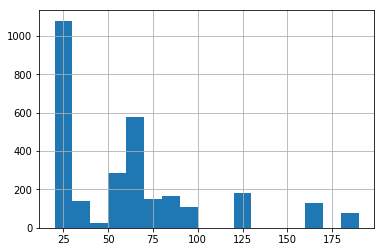

In [8]:
merged.MSSubClass.hist(bins=np.arange(merged.MSSubClass.unique().min(), merged.MSSubClass.unique().max() + 10, 10))

In [24]:
objectView = merged.select_dtypes(include=['object'])
print(objectView.shape[1])
for column in objectView.columns:
    print(column)
    print(merged[column].value_counts())
    print('__________________________________________')

43
MSZoning
RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64
__________________________________________
Street
Pave    2907
Grvl      12
Name: Street, dtype: int64
__________________________________________
Alley
Grvl    120
Pave     78
Name: Alley, dtype: int64
__________________________________________
LotShape
Reg    1859
IR1     968
IR2      76
IR3      16
Name: LotShape, dtype: int64
__________________________________________
LandContour
Lvl    2622
HLS     120
Bnk     117
Low      60
Name: LandContour, dtype: int64
__________________________________________
Utilities
AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64
__________________________________________
LotConfig
Inside     2133
Corner      511
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64
__________________________________________
LandSlope
Gtl    2778
Mod     125
Sev      16
Name: LandSlope, dtype: int64
__________________

In [26]:
merged.MiscFeature[pd.notnull(merged.MiscFeature)].value_counts()

Shed    95
Gar2     5
Othr     4
TenC     1
Name: MiscFeature, dtype: int64

In [32]:
merged.select_dtypes(exclude=['object']).dtypes.value_counts()

int64      26
float64    12
dtype: int64

In [33]:
merged.select_dtypes(exclude=['object']).dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1       float64
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath     float64
BsmtHalfBath     float64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars       float64
GarageArea       float64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice        float64
dtype: object

In [39]:
merged.LotFrontage.value_counts()

60.0     276
80.0     137
70.0     133
50.0     117
75.0     105
65.0      93
85.0      76
21.0      50
24.0      49
63.0      47
78.0      46
90.0      46
68.0      44
64.0      43
74.0      39
72.0      39
73.0      33
62.0      31
52.0      28
100.0     28
82.0      28
79.0      28
51.0      27
59.0      27
57.0      26
66.0      26
76.0      25
53.0      24
55.0      24
43.0      23
        ... 
140.0      2
122.0      2
116.0      2
149.0      2
150.0      2
174.0      2
25.0       1
123.0      1
135.0      1
111.0      1
117.0      1
131.0      1
200.0      1
22.0       1
136.0      1
28.0       1
31.0       1
133.0      1
155.0      1
153.0      1
126.0      1
152.0      1
168.0      1
144.0      1
138.0      1
137.0      1
182.0      1
119.0      1
195.0      1
141.0      1
Name: LotFrontage, Length: 128, dtype: int64

In [38]:
merged.loc[pd.isna(merged.FireplaceQu)].Fireplaces.sum()

0

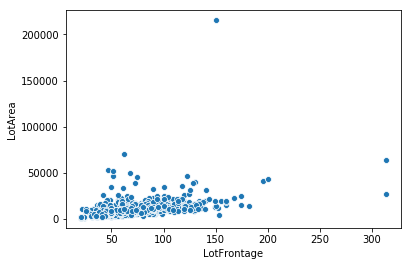

In [41]:
lotAndFrontage=merged.loc[pd.notnull(merged.LotFrontage)]
sns.scatterplot(data=lotAndFrontage, x='LotFrontage', y='LotArea')

In [52]:
garageFeatures = [x for x in list(merged.select_dtypes(include=['object']).columns) if 'Garage' in x]

print(merged.loc[:, garageFeatures].dropna(axis=0, how='all').shape)
print(merged.loc[:, garageFeatures].dropna(axis=0, how='any').shape)

print(merged.shape[0])
print(pd.isna(merged.GarageCond).sum())

(2762, 4)
(2760, 4)
2919
159


In [57]:
bsmtFeatures = [x for x in list(merged.select_dtypes(include=['object']).columns) if 'Bsmt' in x]

print(merged.loc[:, bsmtFeatures].dropna(axis=0, how='all').shape)
print(merged.loc[:, bsmtFeatures].dropna(axis=0, how='any').shape)

print(merged.shape[0])
print(pd.isna(merged.BsmtQual).sum())

(2840, 5)
(2831, 5)
2919
81


['MasVnrType', 'MasVnrArea']
(2896, 2)
(2895, 2)


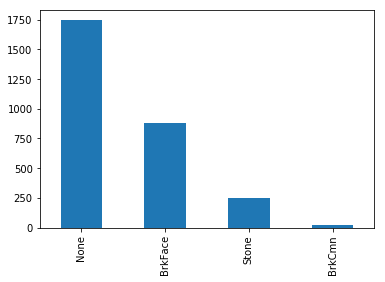

In [64]:
    

masFeatures = [x for x in list(merged.columns) if 'Mas' in x]
print(masFeatures)

print(merged.loc[:, masFeatures].dropna(axis=0, how='all').shape)
print(merged.loc[:, masFeatures].dropna(axis=0, how='any').shape)

merged.MasVnrType.value_counts().plot(kind='bar')

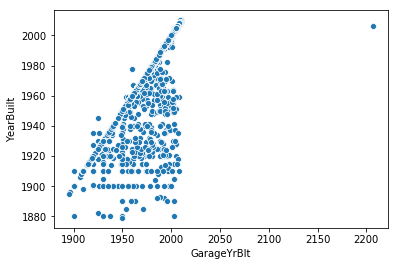

In [83]:
yrb = merged.loc[pd.notnull(merged.GarageYrBlt) & pd.notnull(merged.YearBuilt)]
sns.scatterplot(x=yrb.GarageYrBlt, y=yrb.YearBuilt)

In [133]:
def customFillna(X:pd.DataFrame):
    X = X.copy()
    # pool
    X['HasPool'] = X.PoolArea.apply(lambda x: int(x > 0))
    X.PoolQC.fillna(value='NA', inplace=True)
    #X.drop(columns=['PoolQC', 'PoolArea'], inplace=True)
    
    X.MiscFeature.fillna(value='NA', inplace=True)
    
    X.Alley.fillna(value='NA', inplace=True)
    
    X.Fence.fillna(value='NA', inplace=True)
    
    X.FireplaceQu.fillna(value='NA', inplace=True)
    
    # lot frontage
    X.LotFrontage.fillna(value=X.LotFrontage.mean(), inplace=True)
    X.drop(columns=['LotFrontage'], inplace=True)
    
    # Garage
    garageObjFeatures = [x for x in list(X.select_dtypes(include=['object']).columns) if 'Garage' in x]
    for feat in garageObjFeatures:
        X[feat].fillna(value='NA', inplace=True)
        
    # Garage year built
    X.GarageYrBlt.fillna(value=0, inplace=True)
    
    # Bsmt
    bsmtFeatures = [x for x in list(X.select_dtypes(include=['object']).columns) if 'Bsmt' in x]
    for feat in bsmtFeatures:
        X[feat].fillna(value='NA', inplace=True)
    
    # Mas
    X.MasVnrArea.fillna(value=0, inplace=True)
    X.MasVnrType.fillna(value='NA', inplace=True)
    
    # Object NA less than 10:
    isnaObjFeats = pd.isnull(X.select_dtypes(include=['object'])).sum()
    isnaObjFeats = list(isnaObjFeats[(isnaObjFeats > 0) & (isnaObjFeats < 10)].index)
    for feat in isnaObjFeats:
        X[feat].fillna(value=X[feat].mode()[0], inplace=True)
        
    # Numerical NA less than 10:
    isnaNumFeats = pd.isnull(X.select_dtypes(exclude=['object'])).sum()
    isnaNumFeats = list(isnaNumFeats[(isnaNumFeats > 0) & (isnaNumFeats < 10)].index)
    for feat in isnaNumFeats:
        X[feat].fillna(value=0, inplace=True)
    
    return X
    

In [134]:
naFilled = customFillna(merged)
na = pd.isna(naFilled).sum()
assert na[na > 0].sort_values().count() == 1

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


C:\Anaconda3x64\envs\ml\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


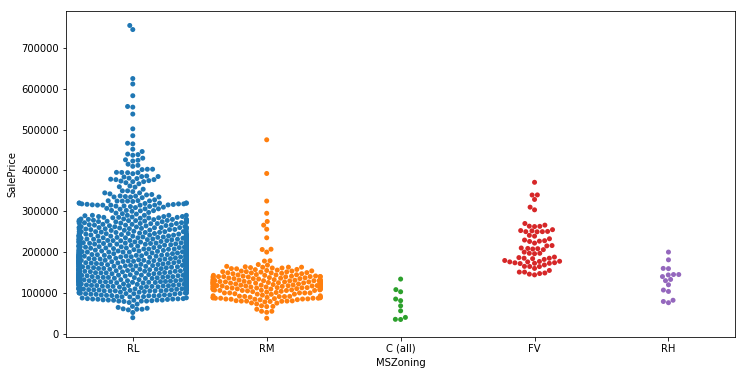

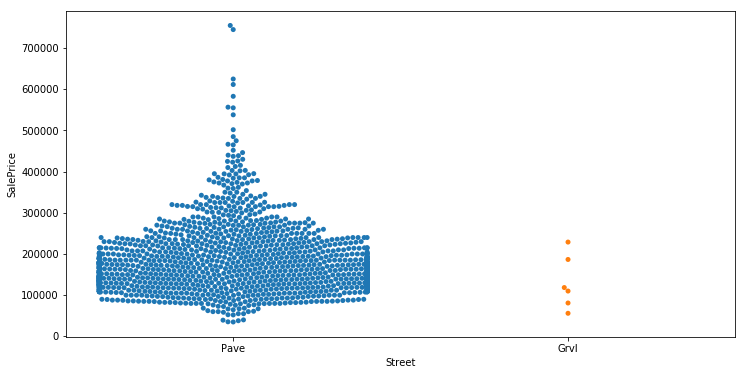

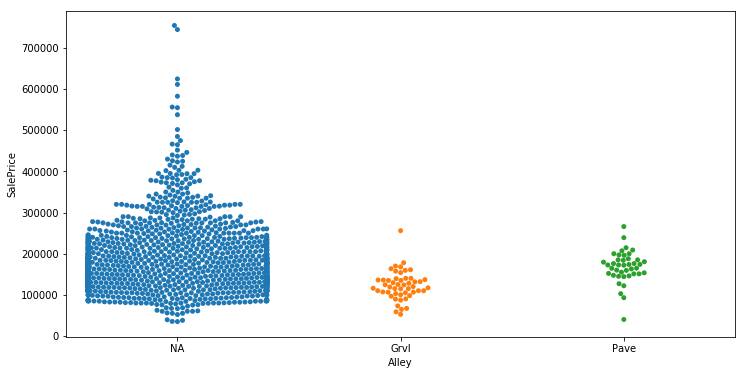

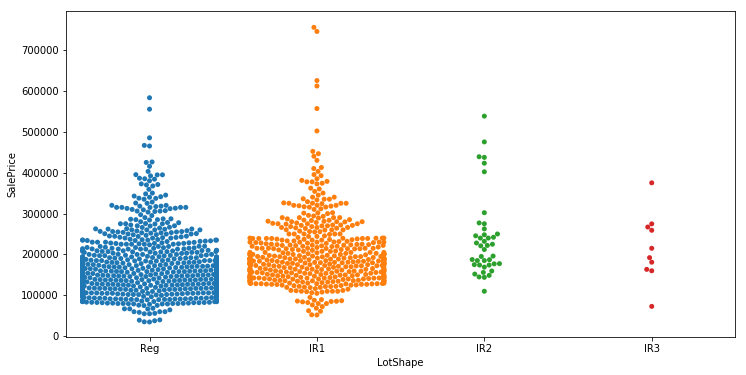

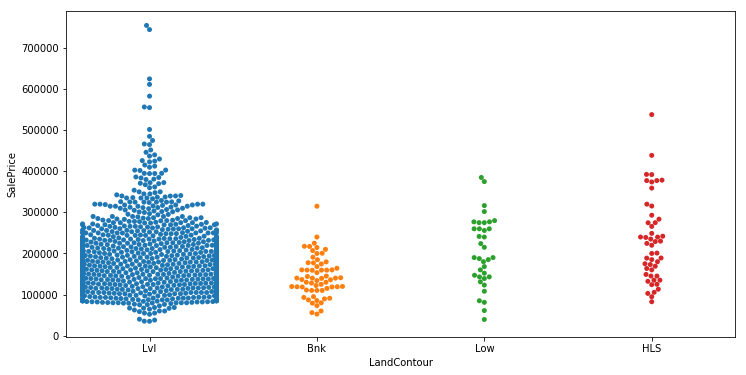

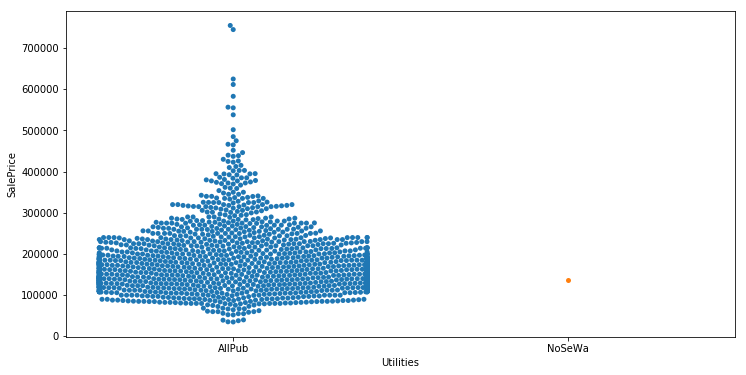

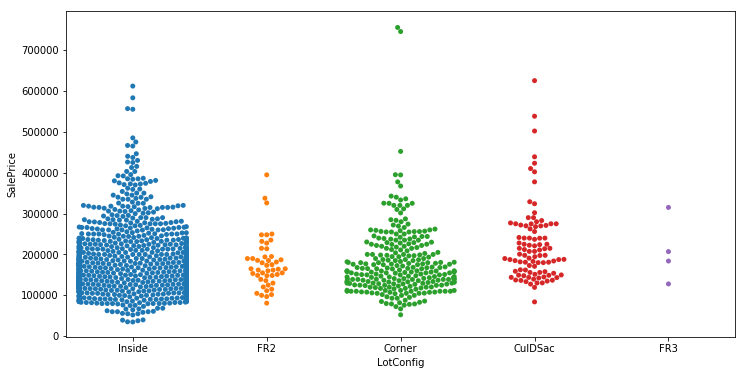

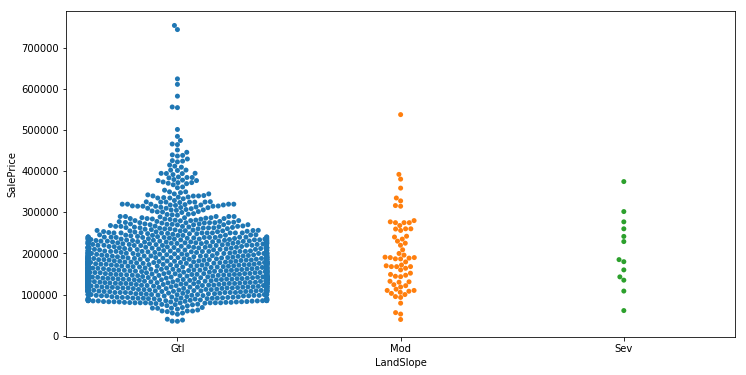

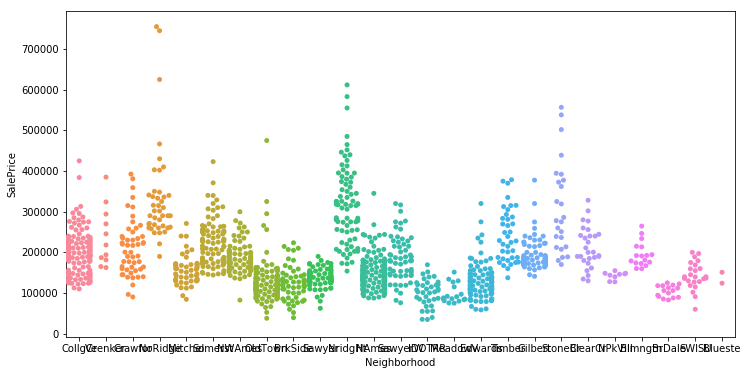

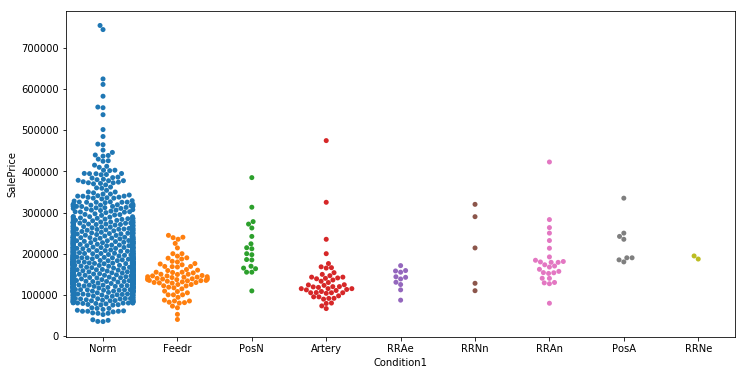

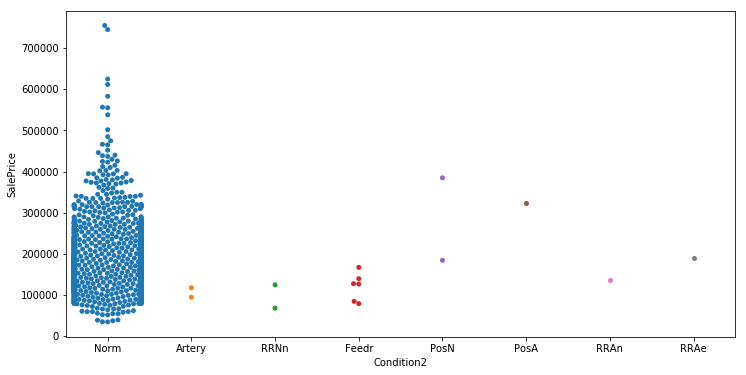

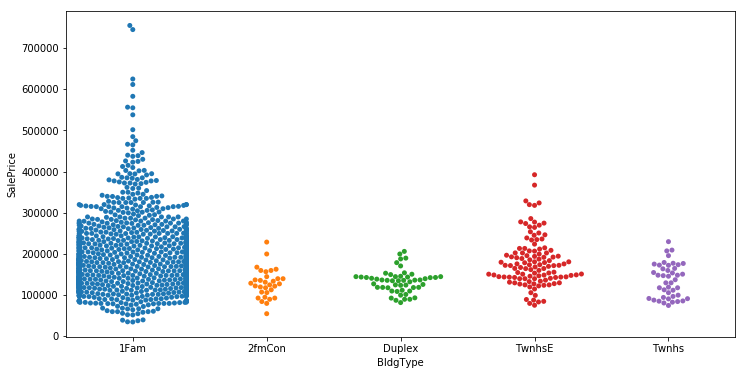

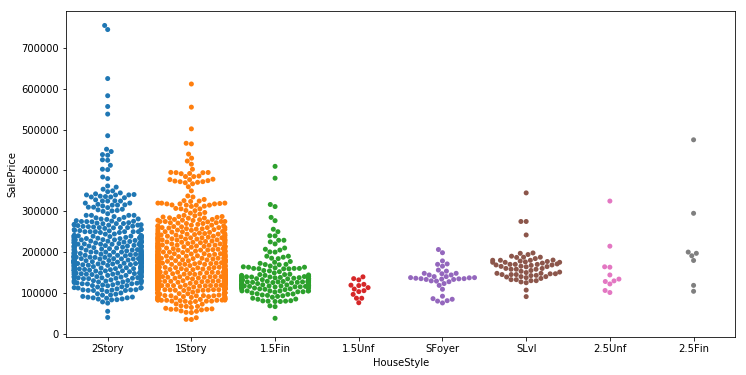

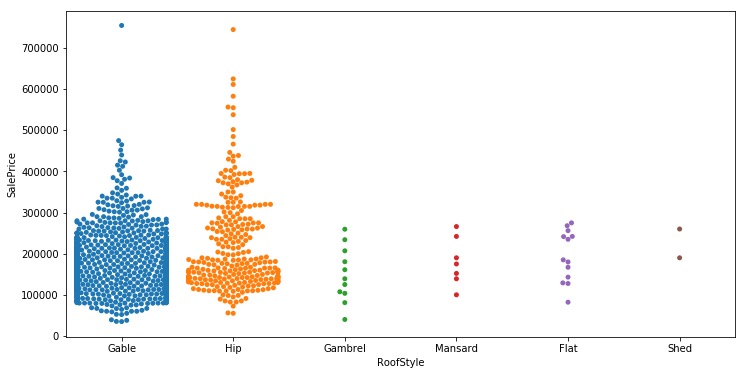

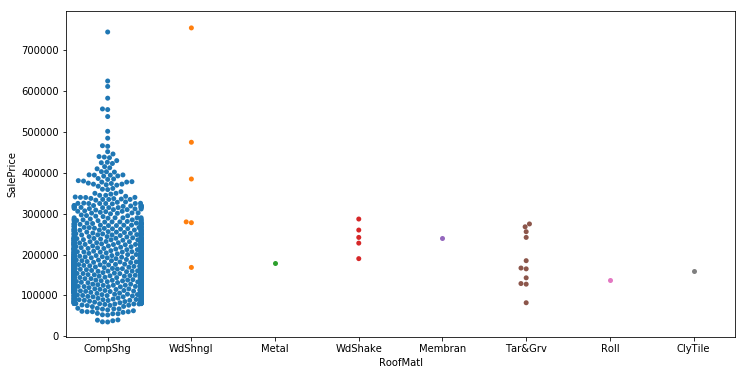

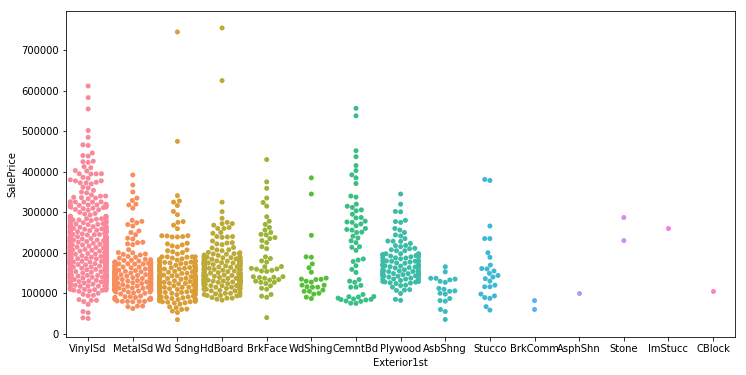

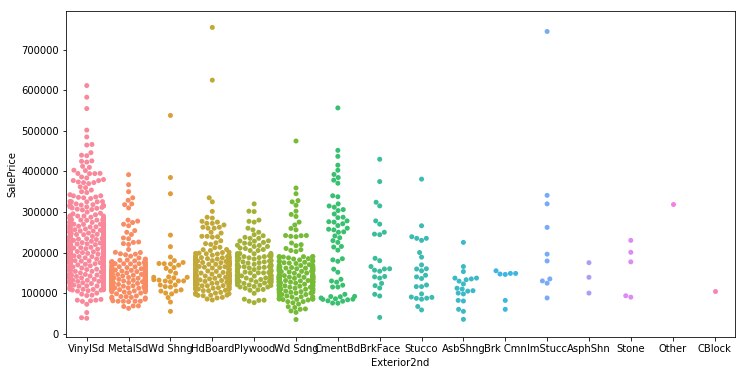

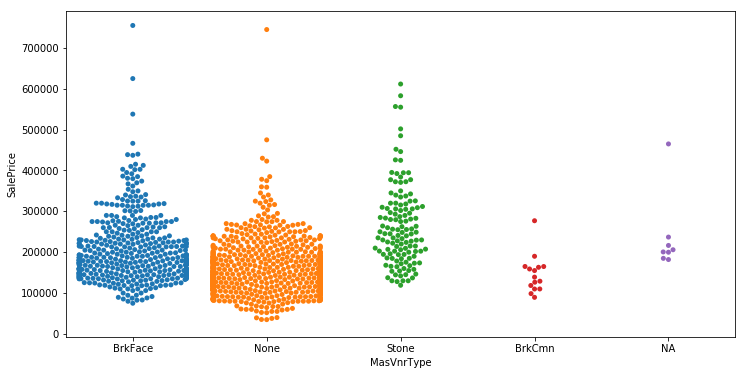

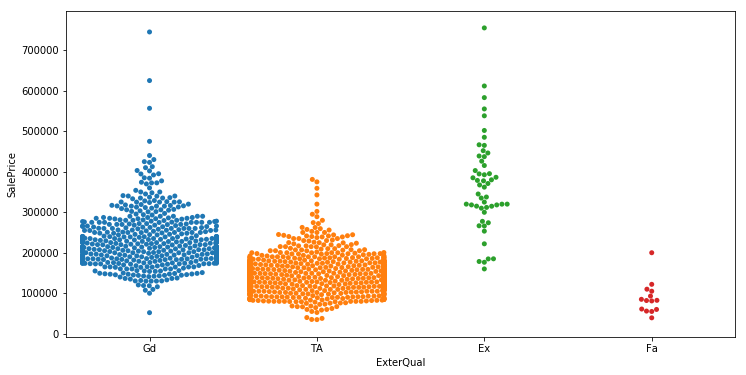

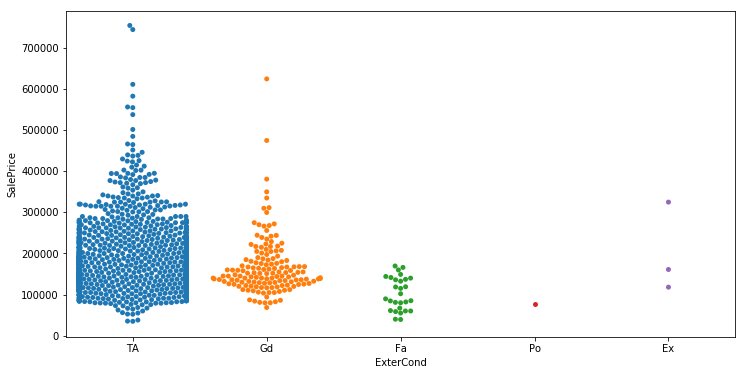

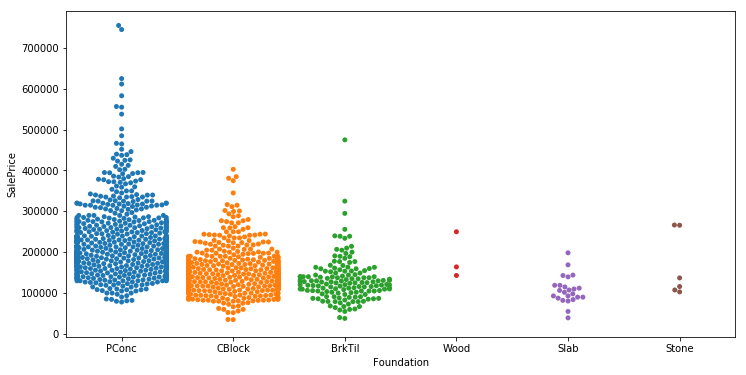

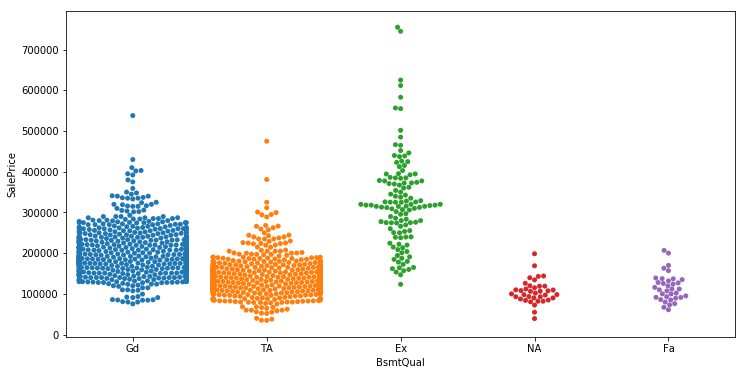

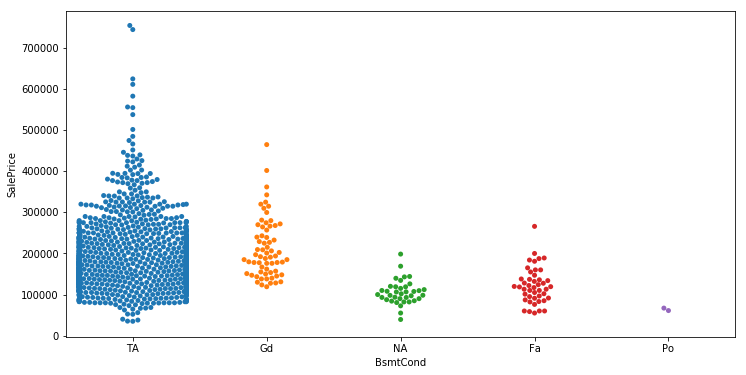

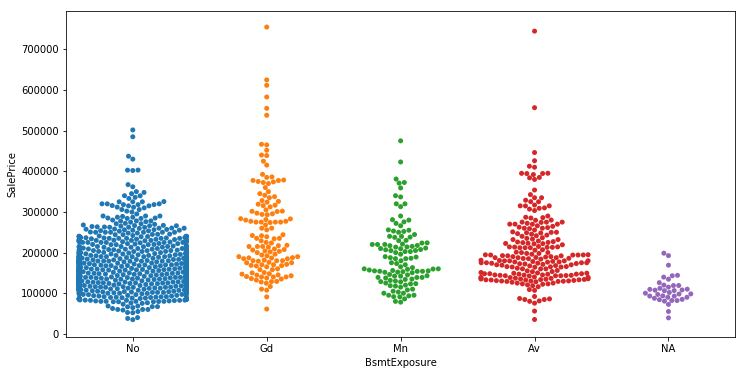

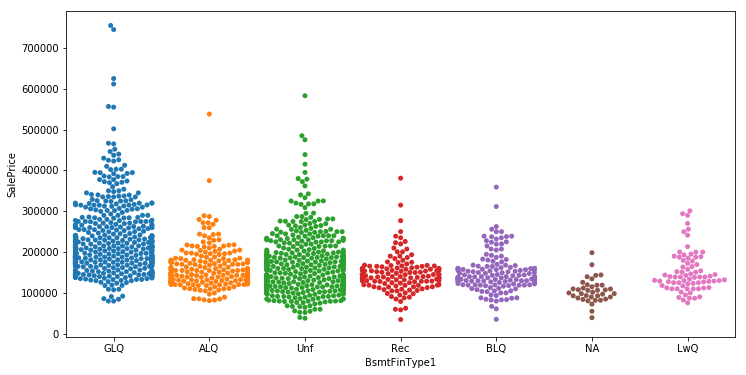

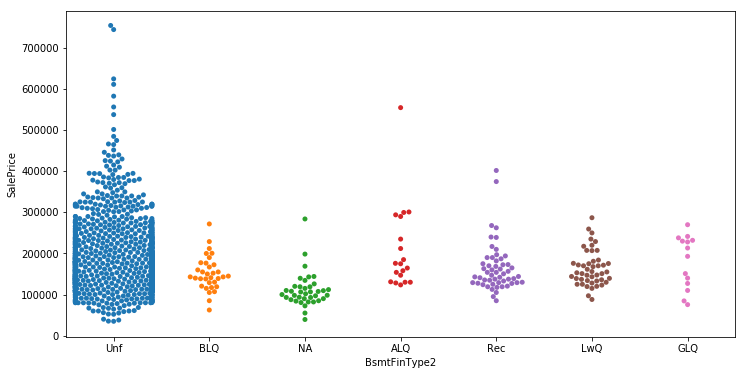

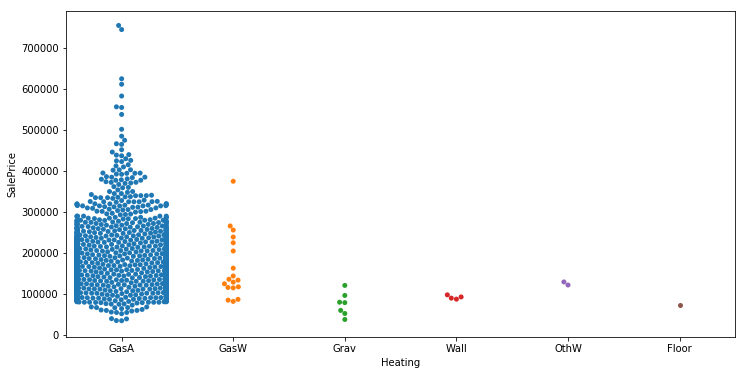

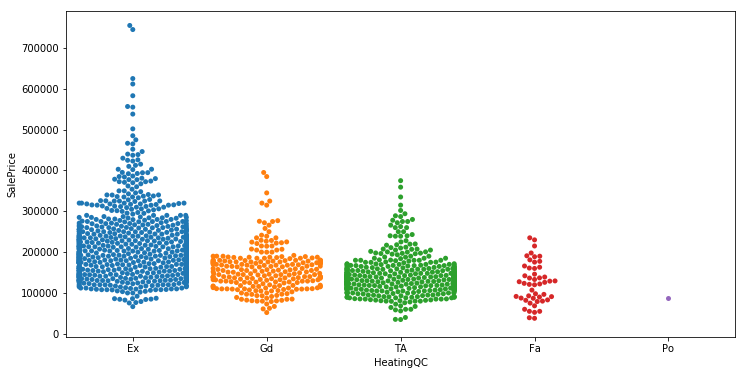

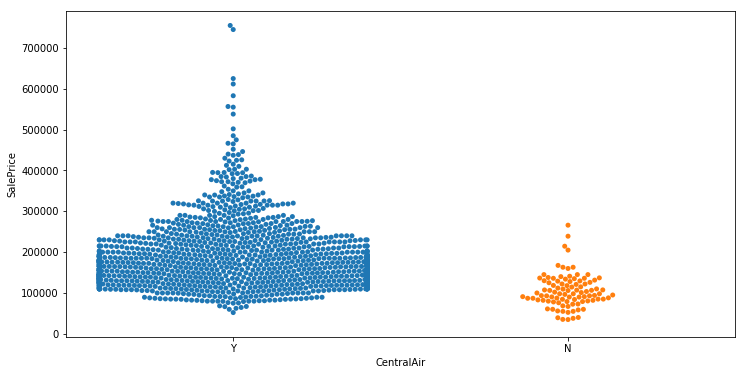

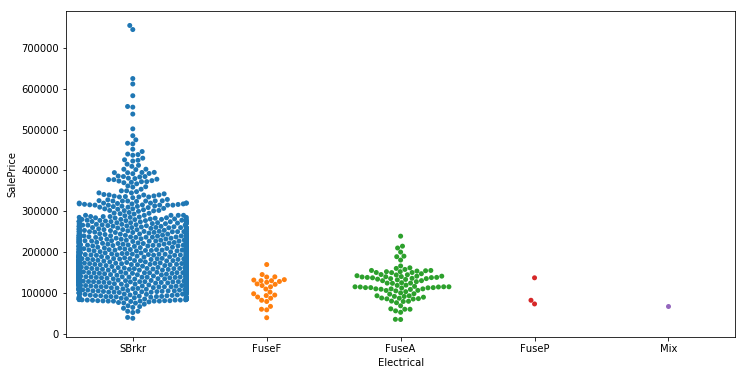

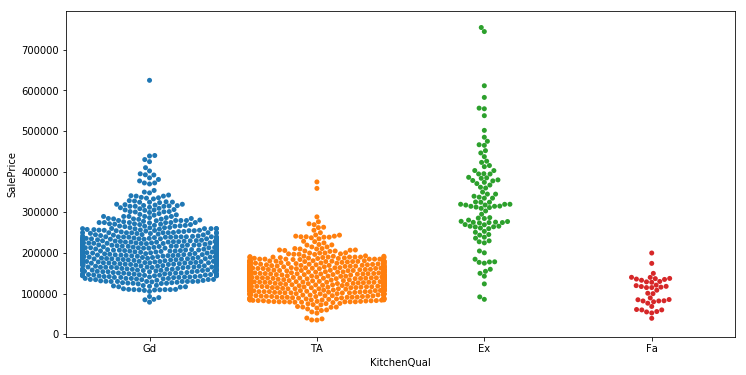

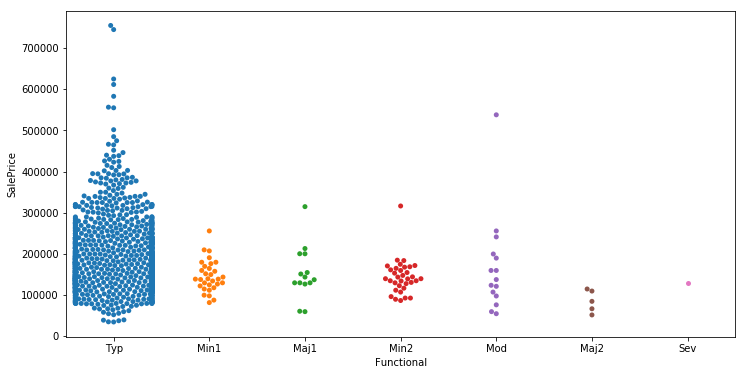

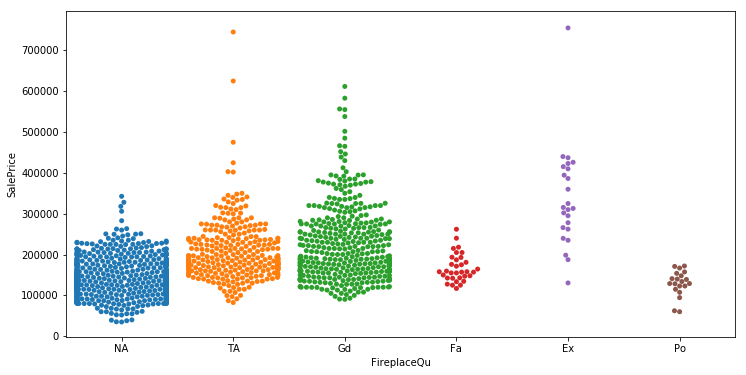

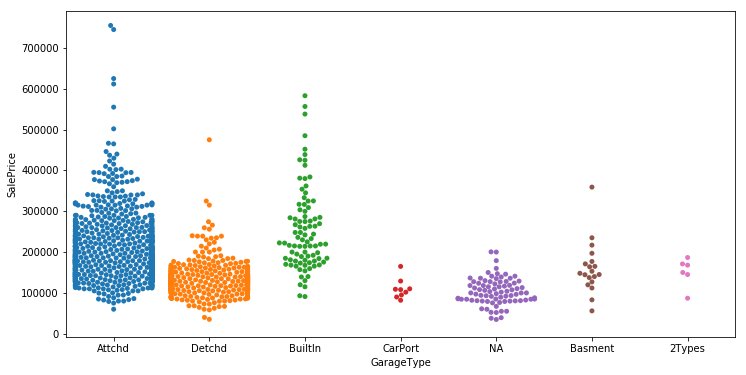

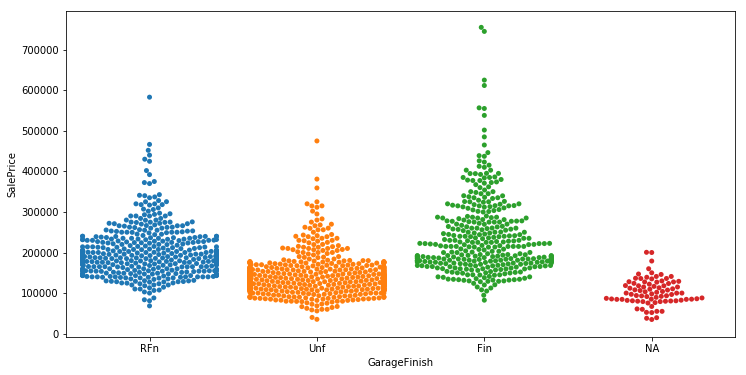

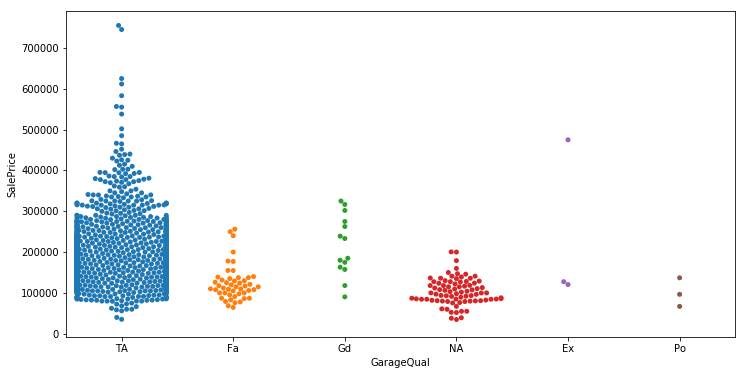

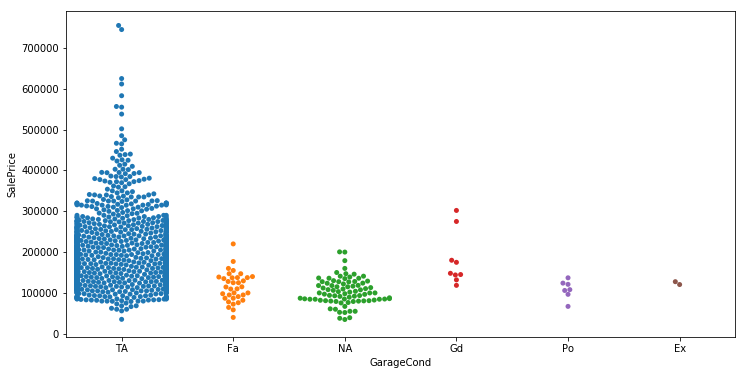

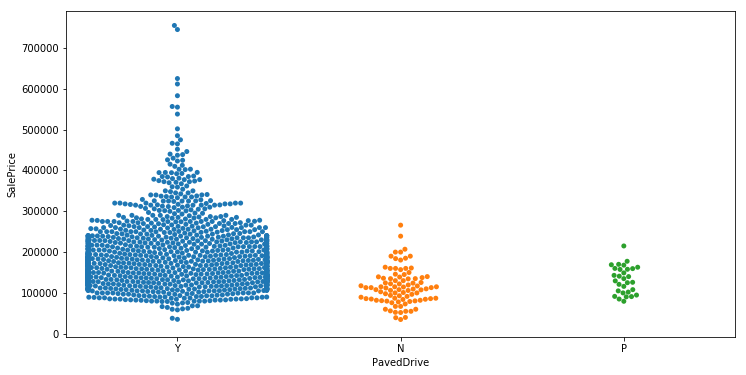

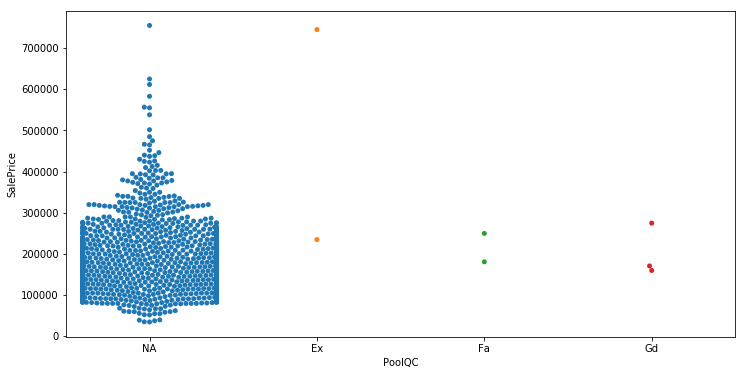

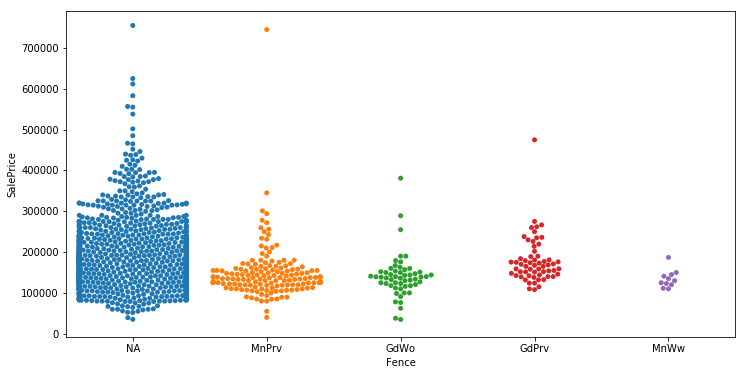

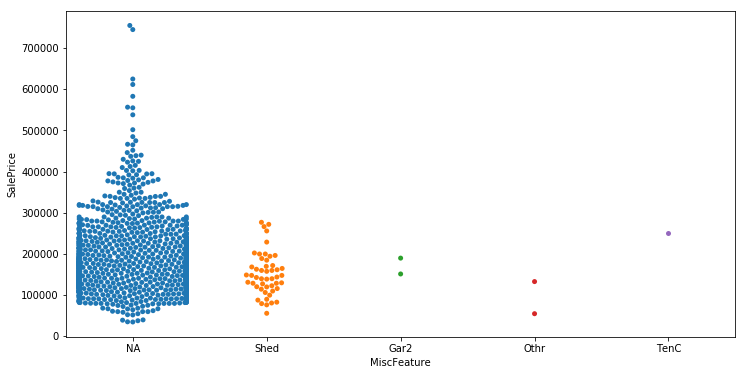

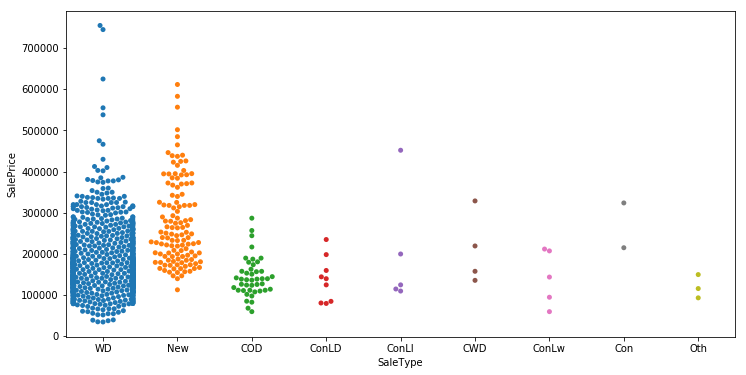

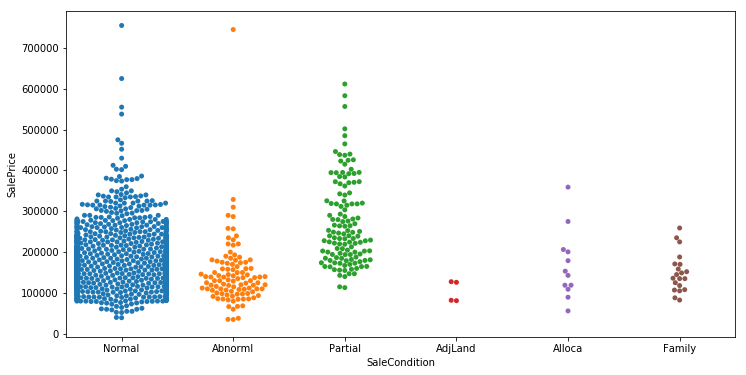

In [132]:
catFeats = list(naFilled.select_dtypes(include=['object']).columns)
print(catFeats)

for idx, feat in enumerate(catFeats):
    plt.figure(figsize=(12, 6))
    sns.swarmplot(x=naFilled[feat], y=naFilled.SalePrice)

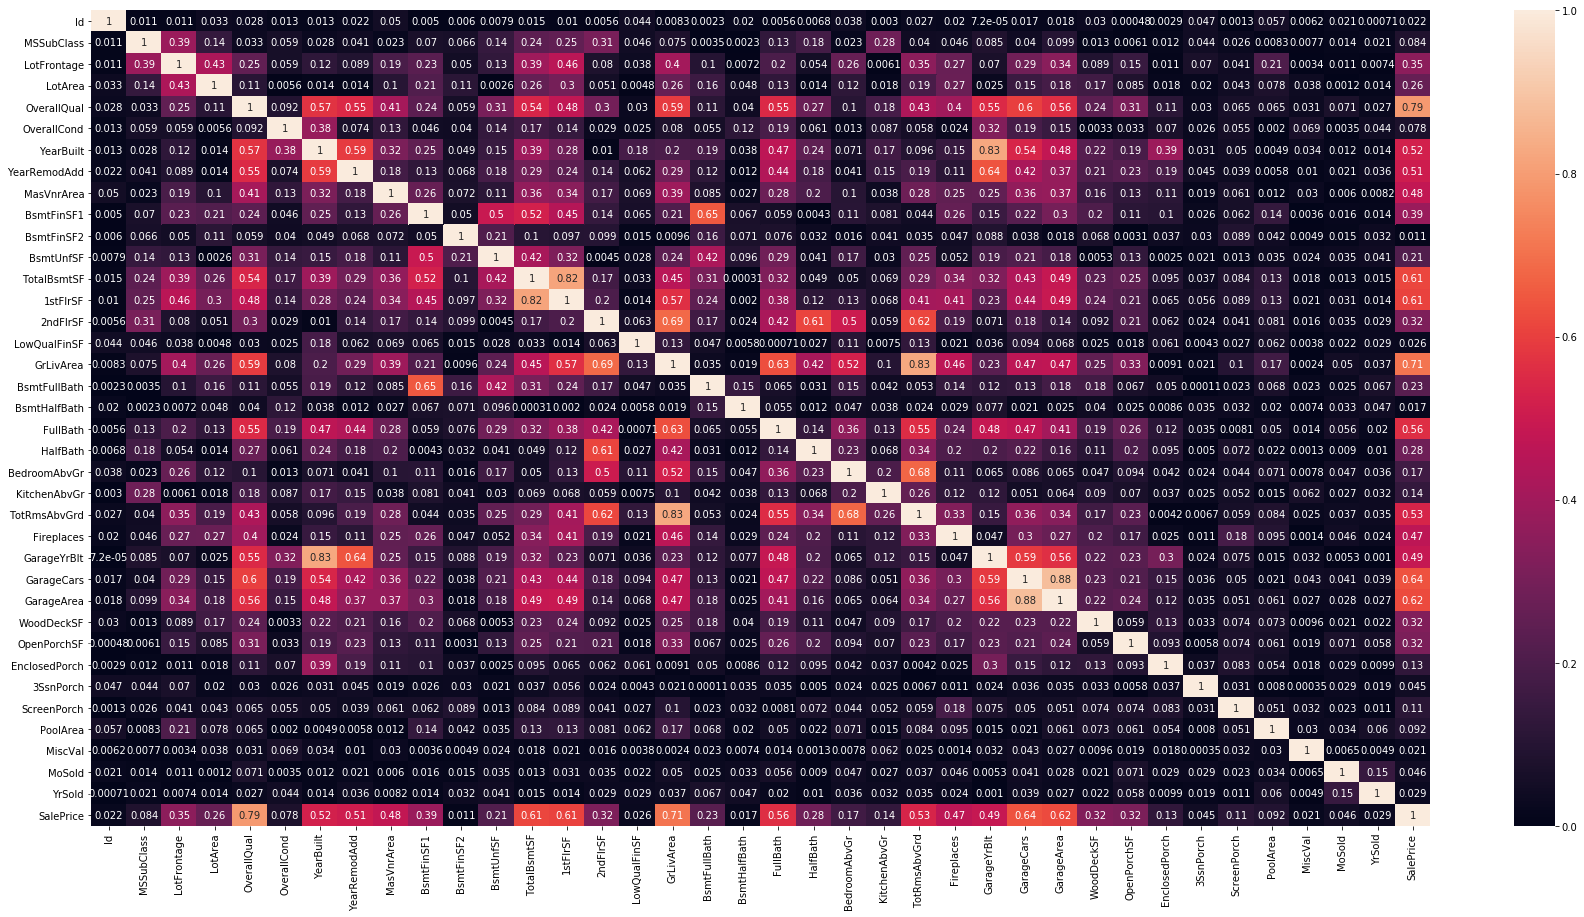

In [139]:
plt.figure(figsize=[30,15])
sns.heatmap(train.corr().abs(), annot=True)

In [148]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

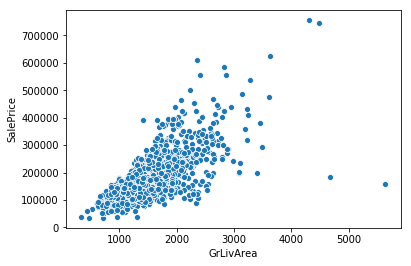

In [150]:
sns.scatterplot(x=train['GrLivArea'], y=train['SalePrice'])

array(['60', '20', '70', '50', '190', '45', '90', '120', '30', '85', '80',
       '160', '75', '180', '40', '150'], dtype=object)

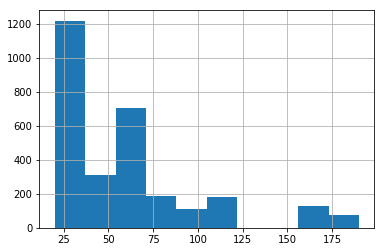

In [161]:
houses=naFilled.copy()
naFilled.MSSubClass.hist()
houses['MSSubClass']=houses['MSSubClass'].astype(str)
houses['MSSubClass'].unique()

In [162]:
from scipy.stats import skew

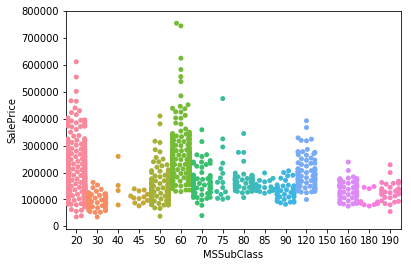

In [164]:
sns.swarmplot(x=naFilled.MSSubClass, y=naFilled.SalePrice)